# Aparición de palabras nuevas en El Quijote, primera parte

En primer lugar, unas funciones utilitarias para lo que sigue.

* **splitear()** toma un texto y devuelve una lista de palabras, ignorando todos los signos de puntuación.
* **calculo()** rastrea todas las palabras de una lista y devuelve la colección de palabras distintas, la colección de todas las palabras, y un par de listas numéricas que son el conteo en cada momento de las palabras distintas y totales encontradas.

In [1]:
import re

def splitear(texto):
    patroncillo = re.compile("\W+")
    texto_limpio = re.sub(patroncillo, " ", texto)  ## Cambiar todos los signos de puntuación por espacios
    palabras = texto_limpio.split()                 ## Partir por los espacios
    return palabras

def calculo(palabras):
    palabras_distintas = []
    palabras_totales = []
    x = []
    y = []
    k = 0
    for i, palabra in enumerate(palabras):
        palabras_totales.append(palabra)
        x.append(i+1)
        if palabra not in palabras_distintas:
            palabras_distintas.append(palabra)
            k += 1
        y.append(k)
    return (palabras_distintas, palabras_totales, x, y)

## Análisis del texto

* **PD**: Un array con todas las palabras distintas del texto.
* **PT**: Un array con todas las palabras del texto, incluidas las que se repiten.
* **X**: Un array con la secuencia numérica de palabras contadas: [1, 2, 3,... 183790]
* **Y**: Un array con el número de palabras no repetidas en cada momento: [1, 2, 3,... 19, 20, 20, ... 15475]

Cuando la cifra en **Y** se repite es que hemos encontrado una palabra ya usada. Así, en el ejemplo, la palabra 21 ya fue utilizada previamente, por tanto no se altera la cuenta en **Y**, siguen habiendo 20 palabras diferentes.

In [2]:
import codecs
PD, PT, X, Y = calculo(splitear(codecs.open("dQ1.txt","r","utf-8").read()))

In [3]:
## Palabras distintas, palabras totales
len(PD), len(PT)

(15475, 183790)

In [50]:
## Curva regresión para el Quijote (coeficientes aproximados a ojo)
import matplotlib.pyplot as plt
from math import sqrt
Y1reg = [40.5 * sqrt(( xx + 1600) ) - 2000 for xx in X]

## Lo mismo con coeficientes calculados más abajo (técnica del gradiente descendiente)
Y3reg = [39.059438065705926 * sqrt(( xx + 91.9948783881707) )  -1395.1646766352567 for xx in X]

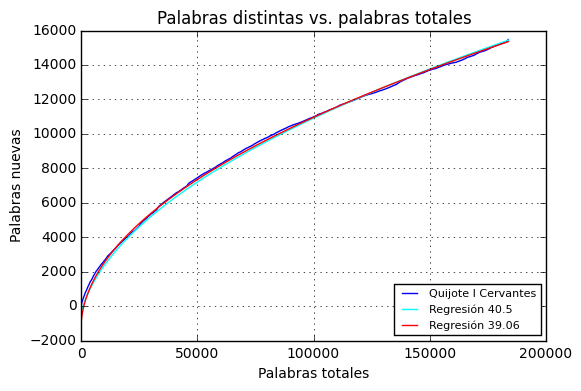

In [145]:
%matplotlib inline
plt.plot(X, Y, color="blue", label="Quijote I Cervantes")
plt.plot(X, Y1reg, color="cyan", label="Regresión 40.5")
plt.plot(X, Y3reg, color="red", label="Regresión 39.06")
plt.legend(loc="lower right", fontsize="8")
plt.xlabel('Palabras totales')
plt.ylabel('Palabras nuevas')
plt.title('Palabras distintas vs. palabras totales')
plt.grid(True)
plt.show()

# Cálculos para la regresión según la función raíz cuadrada

Básicamente se trata de encontrar una función $f(x) = \theta_{0} \sqrt{ x + \theta_{1} } + \theta_{2}$ que ajuste con el mínimo error posible la forma de la gráfica original.

El primer coeficiente es el más importante, porque determina la amplitud de la curva.

El segundo coeficiente hace un ajuste moviendo la curva en un sentido horizontal.

El tercer coeficiente hace el ajuste en vertical.

La regresión se hace con el método del gradiente descendiente, ajustando los tres coeficientes citados para minimizar el error respecto a la curva original.

In [32]:
from math import sqrt

def J(x, theta0, theta1, theta2):
    """Devuelve la predicción J(x) de valor de y para un x dado, en función de los coeficientes"""
    valor = None
    try:
        valor = theta0 * sqrt(x + theta1) + theta2
    except:
        print("x, valor, thetas:", x, valor, theta0, theta1, theta2)
        print(1/0)  ## Una forma un tanto bestia de salir del proceso si hay un error   
    return valor

def Costo(X, Y, theta0, theta1, theta2):
    """"El costo es la suma de los errores al cuadrado. Se trata de que sea lo menor posible"""
    m = len(X)
    costo = 0
    for i, x in enumerate(X):
        costo += 2 / m * (J(X[i], theta0, theta1, theta2) - Y[i]) ** 2
    return costo

def iteracion(X, Y, alpha, m, theta0, theta1, theta2):
    """Proceso por el que se recalculan los coeficientes (para cada paso)"""
    dJtheta0 = dJtheta1 = dJtheta2 = 0
    for i, x in enumerate(X):
        sqrtXiTheta1 = sqrt(X[i] + theta1)
        fixterm = 2 / m * ( theta0 * sqrtXiTheta1 + theta2 - Y[i])
        
        dJtheta0 += fixterm * sqrtXiTheta1
        dJtheta1 += fixterm * theta0 / 2 / sqrtXiTheta1
        dJtheta2 += fixterm      
    theta0 = theta0 - alpha * dJtheta0
    theta1 = theta1 - alpha * dJtheta1
    theta2 = theta2 - alpha * dJtheta2
    return (theta0, theta1, theta2)

def GradientDescent(X, Y, iteraciones, alpha, epsilon, Theta):
    """El método del gradiente descendiente para optimizar los coeficientes"""
    costo_ant = None
    m = len(X)
    
    def Jnew(x):
        return J(x, * Theta)
    
    while iteraciones:
        Theta = iteracion(X, Y, alpha, m, *Theta)
        costo = Costo(X, Y, *Theta)
        #print(iteraciones, costo, Theta)
        if costo_ant:
            if abs(costo_ant - costo) <= epsilon:
                print("\nFIN por EPSILON", iteraciones)
                return Jnew, Theta
                break
            if costo < costo_ant:
                print("-", end=str(Theta[0]))
            else:
                print("+", end=str(Theta[0]))
        costo_ant = costo
        iteraciones -= 1
    else:
        print("\nFIN por ITER")
    return Jnew, Theta
    print("\nFIN")   

## Distintas iteraciones a la búsqueda de los coeficientes óptimos

El algoritmo del gradiente descendiente para la función raíz cuadrada tiene un problema particular, y es el hecho de que el dominio de esta función no incluye valores negativos para **x**. Esto limita los posibles valores de **$\alpha$**, ya que si este parámetro es grande en ocasiones genera dichos valores negativos.

También es sensible el algoritmo a la elección de un buen valor inicial para los parámetros. En esta primera iteración se usó un valor $\theta_{0} = 40.5$

In [11]:
iteraciones = 1000
alpha = .00001
epsilon = 0.01
Theta = (40.5, 0, 0)
JJ1, ThetaEnd = GradientDescent(X, Y, iteraciones, alpha, epsilon, Theta)
YY1 = [(JJ1(x) - y) for x, y in zip(X, Y)]

-38.78393570952856-31.350799708786226-37.579098695168284-32.36034469148883-36.73319085871187-33.069139326734-36.13928474589359-33.56677919772555-35.72230732159105-33.91616875132292-35.429550320736276-34.16147276990914-35.22400763052269-34.333699045466005-35.07969751197085-34.454617936901776-34.9783783636479-34.53951426447305-34.90724288181266-34.59911939605763-34.85729914600661-34.640967751726876-34.82223399030781-34.67034919633844-34.79761498405333-34.69097770786913-34.78033014795665-34.70546084488293-34.768194582621405-34.71562935643297-34.759674285108524-34.722768598921995-34.75369224243457-34.72778101229892-34.74949229114189-34.73130019348659-34.74654353403292-34.73377098655575-34.74447323181235-34.73550571348938-34.7430196867674-34.736723653418-34.741999162721804-34.73757876072104-34.741282659761495-34.73817912571651-34.74077960792817-34.738600637878186-34.740426418672754-34.738896578687154-34.7401784469095-34.73910435670732-34.740004347628606
FIN por EPSILON 946


In [12]:
## El valor final de los parámetros (en realidad aquí se modificó el algoritmo del gradiente descendiente 
## para que no calculara nada más que el primer parámetro)
ThetaEnd

(34.739250236235776, 0, 0)

In [15]:
## Si sólo se calcula el primer parámetro, el costo es alto, comparado con dar valores buenos al segundo y tercero.
Costo(X, Y, *ThetaEnd)

328380.08423519816

In [24]:
## La diferencia de costo es notable (los valores de los parámetros aquí se ajustaron a ojo sobre las gráficas)
Costo(X, Y, 40.5, 1600, -2000)

60788.74547557179

## Segundo intento de búsqueda de parámetros

Este intento tampoco recalcula los parámetros 2 y 3.

La idea en estos casos era que la regresión fuera sobre una sola variable. Naturalmente, eso significaría conformarse con un error mayor, pero si de lo que se trata es de comparar varias textos, no es tan importante que el error sea mínimo como que sea comparable con otros valores.

De todos modos, al final opté por optimizar los tres coeficientes, así que esto queda aquí sólo como testimonio.

In [26]:
iteraciones = 1000
alpha = .00001
epsilon = 0.01
Theta = (30, 90, -1400)
JJ2, ThetaEnd = GradientDescent(X, Y, iteraciones, alpha, epsilon, Theta)

-32.67606827182822-44.44804542072866-34.56299848902543-42.86357124804604-35.893497296568725-41.746338094363864-36.8316491480472-40.958562603158875-37.493152105766995-40.40309195453187-37.95958636412554-40.011422443445646-38.288475169279785-39.7352512248696-38.520378903230274-39.54051934043402-38.683897213909674-39.40321137977342-38.799196081555976-39.30639376762213-38.880494798655526-39.23812642188648-38.937819571543216-39.18999023684496-38.97824000748442-39.15604879258076-39.00674097764752-39.132116242925115-39.02683737891886-39.11524109381355-39.04100761037933-39.10334220875387-39.05099922315279-39.09495215159187-39.05804443805229-39.08903621418862-39.06301210984918-39.08486481050405-39.06651487923715-39.08192350002128-39.06898472706264-39.07984954410373-39.07072624858617-39.078387171065216-39.07195421785033-39.0773560329944-39.07282007479978-39.076628964255384-39.073430601690625-39.076116298719874-39.07386109206744-39.07575481164556-39.07416463637861-39.075499922452025-39.0743786693

In [27]:
ThetaEnd

(39.075193469923136, 90, -1400)

In [28]:
## Este coste es la mitad del anterior, en parte debido a usar valores distintos de cero para los parámetros 2 y 3
Costo(X, Y, 39.075193469923136, 90, -1400)

28937.8330872904

## Tercer intento de búsqueda de parámetros

En este caso tomamos como punto de partida los parámetros encontrados en el paso anterior, pero ahora usamos las fórmulas de regresión para recalcular los tres parámetros a la vez. Se verá de todos modos que los parámetros 2 y 3 varían muy poco.

In [ ]:
iteraciones = 1000
alpha = .00001
epsilon = 0.01
Theta = (39.075193469923136, 90, -1400)
JJQ1, ThetaEnd = GradientDescent(X, Y, iteraciones, alpha, epsilon, Theta)

## SUPRIMIDA LA SALIDA POR ABREVIAR

In [34]:
ThetaEnd

(39.07346921265805, 90.18299232600901, -1399.5550132128285)

In [146]:
## La reducción del costo es muy pequeña, respecto al caso anterior.
## Tampoco cambian mucho los coeficientes, señal de que ya estábamos muy cerca del valor óptimo
Costo(X, Y, 39.07346921265805, 90.18299232600901, -1399.5550132128285)

28891.515851198277

## Gráfica para comprobar el ajuste de la regresión calculada

La imagen habla por sí misma, el ajuste es estupendo.

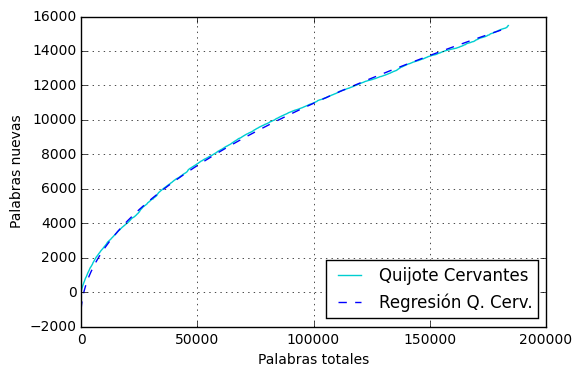

In [37]:
%matplotlib inline
plt.plot(X, Y, color="darkturquoise", label="Quijote Cervantes")
YY = [JJQ1(x) for x in X]
plt.plot(X, YY, color="blue", linestyle="--", label="Regresión Q. Cerv.")

plt.legend(loc="lower right")
plt.xlabel('Palabras totales')
plt.ylabel('Palabras nuevas')
plt.grid(True)
plt.show()

## Un último intento de mejora de los coeficientes

Para este último intento, uso como valores iniciales los calculados anteriormente, que ya sabemos que son cuasi-óptimos.

Además hacemos 10000 iteraciones en lugar de 1000, con la esperanza de llegar a un valor realmente óptimo.

El inconveniente es que 10000 iteraciones tardan una media hora (en mi máquina), así que paciencia si quieres reejecutar el código.

In [ ]:
iteraciones = 10000
alpha = .00001
epsilon = 0.001
Theta = (39.07346921265805, 90.18299232600901, -1399.5550132128285)
JJQ2, ThetaEnd2 = GradientDescent(X, Y, iteraciones, alpha, epsilon, Theta)

## SUPRIMIDA LA SALIDA POR ABREVIAR

In [39]:
## El primer parámetro baja de 39,07 a 39,06. También el tercero cambia un poco.
ThetaEnd2

(39.059438065705926, 91.9948783881707, -1395.1646766352567)

In [40]:
## Una reducción desde 28891, aunque tampoco muy significativa
Costo(X, Y, 39.059438065705926, 91.9948783881707, -1395.1646766352567)

28440.33159995652

In [54]:
## Curiosamente, el costo reduciendo cifras significativas nos lleva a un mínimo mejor
## Usaremos estos valores para la gráfica siguiente
Costo(X, Y, 39.06, 91.99, -1395.)

28426.4416591831

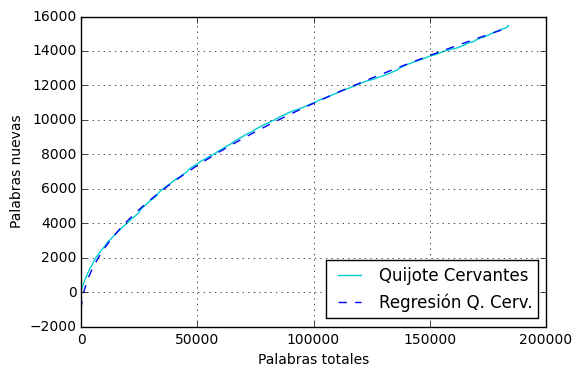

In [55]:
%matplotlib inline

plt.plot(X, Y, color="darkturquoise", label="Quijote Cervantes")
YY = [JJQ2(x) for x in X]
YYfinal = [39.06 * sqrt(( xx + 91.99) )  -1395. for xx in X]
plt.plot(X, YYfinal, color="blue", linestyle="--", label="Regresión Q. Cerv.")

plt.legend(loc="lower right")
plt.xlabel('Palabras totales')
plt.ylabel('Palabras nuevas')
plt.grid(True)
plt.show()

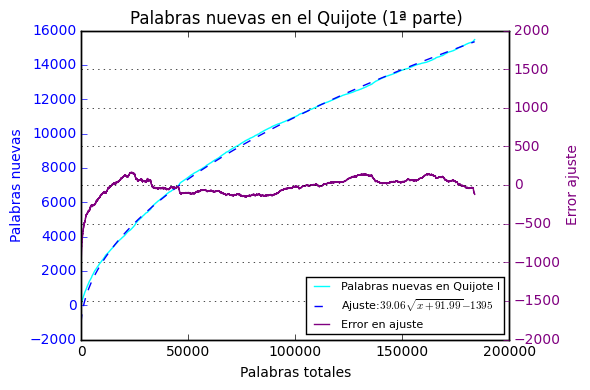

In [148]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

## La gráfica de los valores encontrados originalmente
l1, = ax1.plot(X, Y, 'cyan')

## La gráfica de los valores predichos por nuestra regresión
l2, = ax1.plot(X, [J(x, 39.06, 91.99, -1395.) for x in X], 'b--')

ax1.set_xlabel('Palabras totales')
ax1.set_ylabel('Palabras nuevas', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title("Palabras nuevas en el Quijote (1ª parte)")

## Gráfica del error debido a la regresión ----
YY3 = [(J(x, 39.06, 91.99, -1395.) - y) for x, y in zip(X, Y)]

ax2 = ax1.twinx()
l3, = ax2.plot(X, YY3, 'purple')

ax2.set_ylabel('Error ajuste', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_ylim(-2000,2000)

ax2.legend([l1, l2, l3],["Palabras nuevas en Quijote I", "Ajuste:" + r"$39.06 \sqrt{x + 91.99} - 1395$", "Error en ajuste"], loc="lower right", fontsize=8)
ax2.grid(True)

fig.tight_layout()
plt.show()

In [142]:
%%latex
$n_{N} = 39.06 \sqrt{n_{T} + 91.99} - 1395$

<IPython.core.display.Latex object>